### Exploratory Data Analysis

In [1]:
from configurations_eda import *
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

from r3_helpers import (chain_snap, correlation_analysis,
                        encode_categorical_features, one_way_ANOVA,
                        normlize_data, regression_report)

**EDA Summary**<br>
<br>
- The data includes:
    - 4 continuous features
    - 1 descrete feature
    - 2 nominal features
- Missing values were 4 only on target feature ```Price```. Missing values have been removed as they will not affet prediction of our model.
- Distributions
    - Discrete feature ```Room``` slightly right-skewed
    - Continuous features ```Price``` and ```Area``` heavily right-skewed while ```Lon``` and ```Lat``` (coordinates) are fairly normally distributed (*Gaussian Distribution*)
- Transformations
    - Log-transformation for normalizing highly skewed distributions
    - Clustering to limit group imbalance, that will also limit skewness
    - Feature engineering might be useful to improve the model generalization

*Log(Price)*

In [2]:
data = (
    # load csv
    pd.read_csv("./data/data_train.csv")
    .pipe(
        chain_snap,
        fn=lambda df: df.isna().sum().sum(),
        msg="o Number of missing",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows that will be removed",
    )
    .drop_duplicates()
    # create log of Price
    .assign(**{"log(Price)": lambda df: np.log(df["Price"])})
)


TARGET = "Price"

# display some info
display(data.head(3))
print(f"o Size dataframe = {data.shape}")

o Number of missing: 4
o Number of duplicate rows that will be removed: 0


,Price,Unnamed: 0,Address,Zip,Area,Room,Lon,Lat,log(Price)
0,425000.0,98,"Lamarckhof 11 I, Amsterdam",1098 TK,68,3,4.944251,52.352317,12.959844
1,520000.0,228,"Kiefskamp 24, Amsterdam",1082 KA,80,2,4.872336,52.330330,13.161584
2,700000.0,693,"Latherusstraat 54, Amsterdam",1032 EC,123,6,4.915060,52.393449,13.458836


o Size dataframe = (739, 9)


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).** 

- **a.** Apply $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **b.** Carry out $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) or a [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) analysis between two **Ordinal** features.
- **c.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **d.** Use an appropriate version of the [t-test](https://www.investopedia.com/terms/t/t-test.asp) or [analysis of variance](https://www.investopedia.com/terms/a/anova.asp) (ANOVA) to study the relationship between **quantitative** and **categorical** variables.   
- **e.** ‼️ whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;
- **f.** If necessary, transform or construct new features and re-apply the same statistical test;


**Nominal Features**

In [3]:
display(data_type_df.loc[lambda x: x["data_type"] == "nominal"].transpose())

# get list of nominal features and remove Education from the list as we analyzed before together with Education-Num
nominal_list = list(data_type_df.loc[lambda x: x["data_type"] == "nominal"].index)

,Address,Zip
data_type,nominal,nominal


Extract some useful features as follows:
- Extrapolate the city from `Address` as it is expected that the house `Price` will depend on the City, most likely Amsterdam having the highest Price on average;
- According to this [link](https://en.youbianku.com/Netherlands) the `Zip` code is based on four digits followed by two letters, e.g. 1234 AB. The first two digits indicate a `City` and a `Region`, the third digit represents the `Location` and the fourth digit represents the `District`. The first letter indicates the `delivery area`, and the second letter indicates the subdivision of the delivery area. Consequently, the postcode and house number uniquely define a postal address. Let's us create several features based on subsection of the Zip code.

In [4]:
# remove any space in the Zip string
data["Zip"] = data["Zip"].str.replace(" ", "")

# create new features from Address and Zip
data = data.assign(
    **{
        "Zip_num": lambda df: df["Zip"].str[:4].astype(int),
        "City": lambda df: df["Address"].str.split().str[-1],
        "City_number": lambda df: df["Zip"].str[0].astype(int),
        "Region": lambda df: df["Zip"].str[1].astype(int),
        "Location": lambda df: df["Zip"].str[2].astype(int),
        "District": lambda df: df["Zip"].str[3].astype(int),
        "Delivery_area": lambda df: df["Zip"].str[4:],
    }
)

# add this new features to the nominal list
nominal_list = nominal_list + [
    "City",
    "City_number",
    "Region",
    "Location",
    "District",
    "Delivery_area",
]

data.head()

,Price,Unnamed: 0,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,City,City_number,Region,Location,District,Delivery_area
0,425000.0,98,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.944251,52.352317,12.959844,1098,Amsterdam,1,0,9,8,TK
1,520000.0,228,"Kiefskamp 24, Amsterdam",1082KA,80,2,4.872336,52.330330,13.161584,1082,Amsterdam,1,0,8,2,KA
2,700000.0,693,"Latherusstraat 54, Amsterdam",1032EC,123,6,4.915060,52.393449,13.458836,1032,Amsterdam,1,0,3,2,EC
3,295000.0,588,"1e Kekerstraat 119, Amsterdam",1104VA,91,3,4.981371,52.313749,12.594731,1104,Amsterdam,1,1,0,4,VA
4,650000.0,885,"Nieuwevaartweg, Amsterdam",1019AL,87,4,4.954376,52.367982,13.384728,1019,Amsterdam,1,0,1,9,AL


This dataset contains only Houses located in Amsterdam. As a consequence, `City_number` can be discarded since its variance is 0.

In [5]:
# Print New Norminal Features
print(f"o Nominal features: {', '.join(nominal_list)}")

o Nominal features: Address, Zip, City, City_number, Region, Location, District, Delivery_area


,test-type,feature,group-var,f-value,eta-squared,df-effect,df-error,p-value,stat-sign,variance,results
0,one way ANOVA,log(Price),Zip_num,7.016,0.417,68,667,0.000,True,Unequal,untrustworthy
1,one way ANOVA,log(Price),Region,87.948,0.107,1,734,0.000,True,Unequal,untrustworthy
2,one way ANOVA,log(Price),Location,31.590,0.258,8,727,0.000,True,Unequal,untrustworthy
3,one way ANOVA,log(Price),District,2.788,0.033,9,726,0.003,True,Unequal,untrustworthy


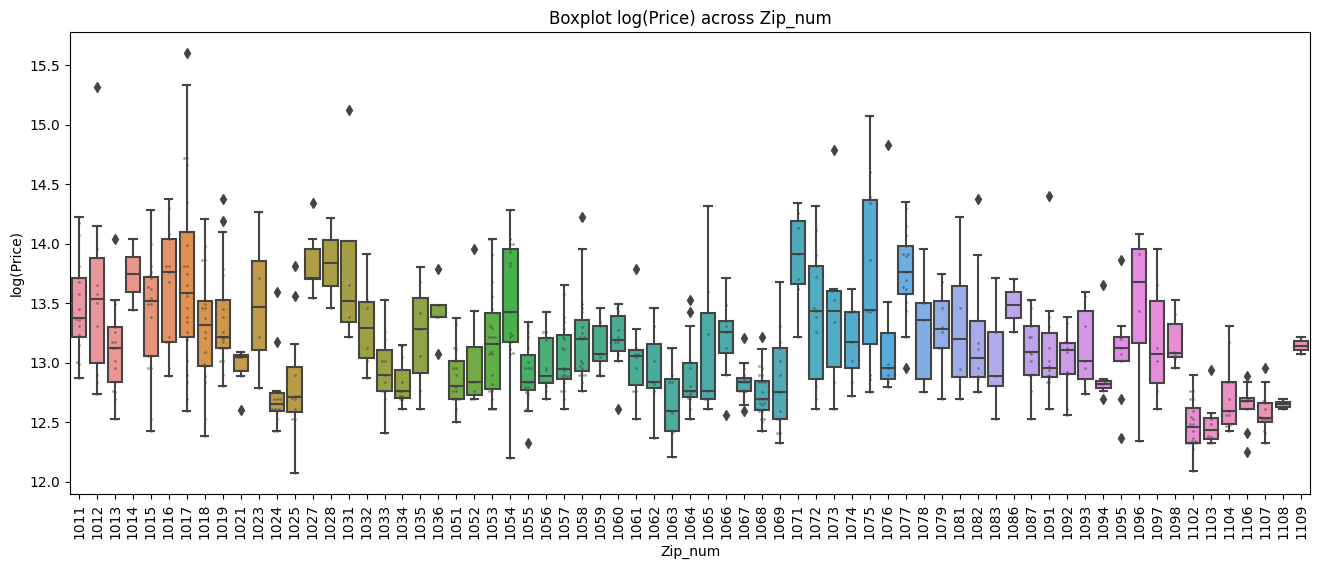

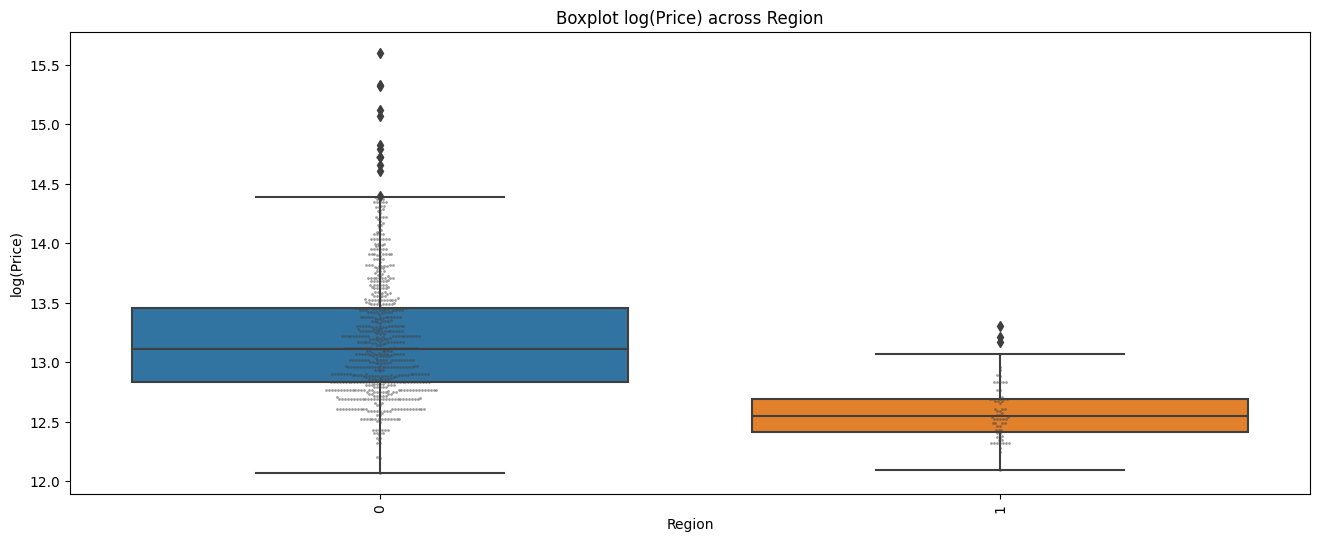

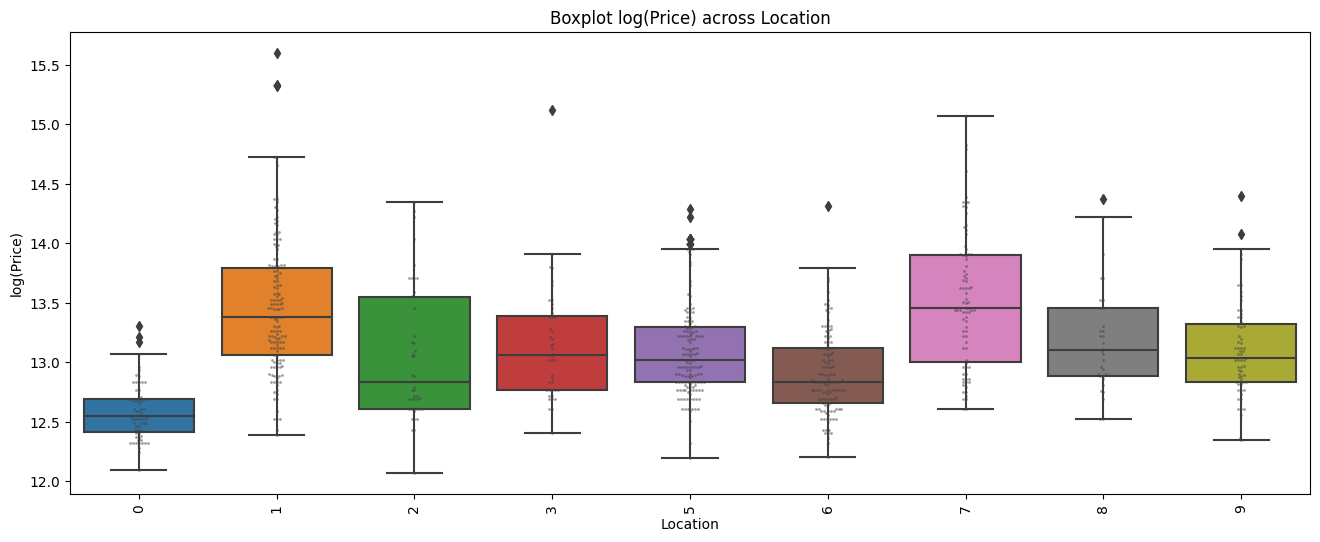

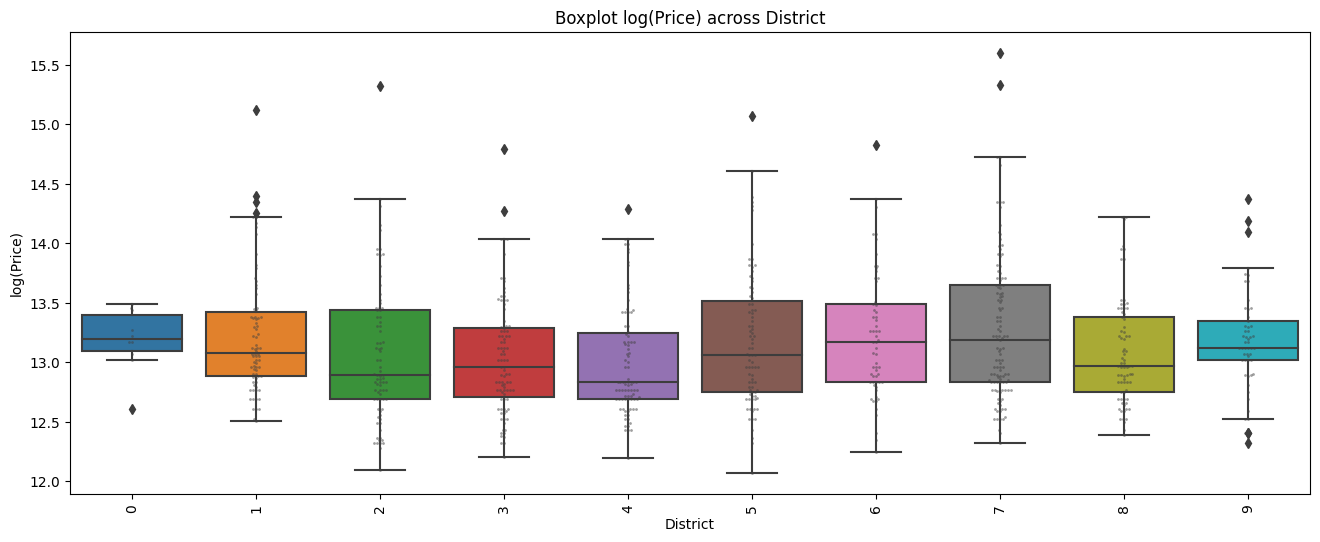

In [6]:
# check if  statistical significance between feature and target
df_summary_anova = pd.DataFrame()

# loop through list
for col in ["Zip_num", "Region", "Location", "District"]:
    # carry out t-test
    df_anova, df_descriptive, _, _ = one_way_ANOVA(
        data=data,
        feature='log(Price)',
        grouping_var=col,
        groups_of_interest=data[col].unique(),
        plot=True,
        figsize=(16, 6)
    )

    # concatenate to summary dataframe
    df_summary_anova = pd.concat([df_summary_anova, df_anova], ignore_index=True)

display(df_summary_anova)

Using a one-way anova we can observe that the `Region` and some of the `Location` have some group difference.

**Discrete & Numerical Features**

In [7]:
# collect quantitative features
quantitative_list = data_type_df.loc[
    lambda x: (x["data_type"] == "discrete") | (x["data_type"] == "continuous")
].index.to_list()
print(f"o Quantitative features: {', '.join(quantitative_list)}")

o Quantitative features: Price, Area, Room, Lon, Lat


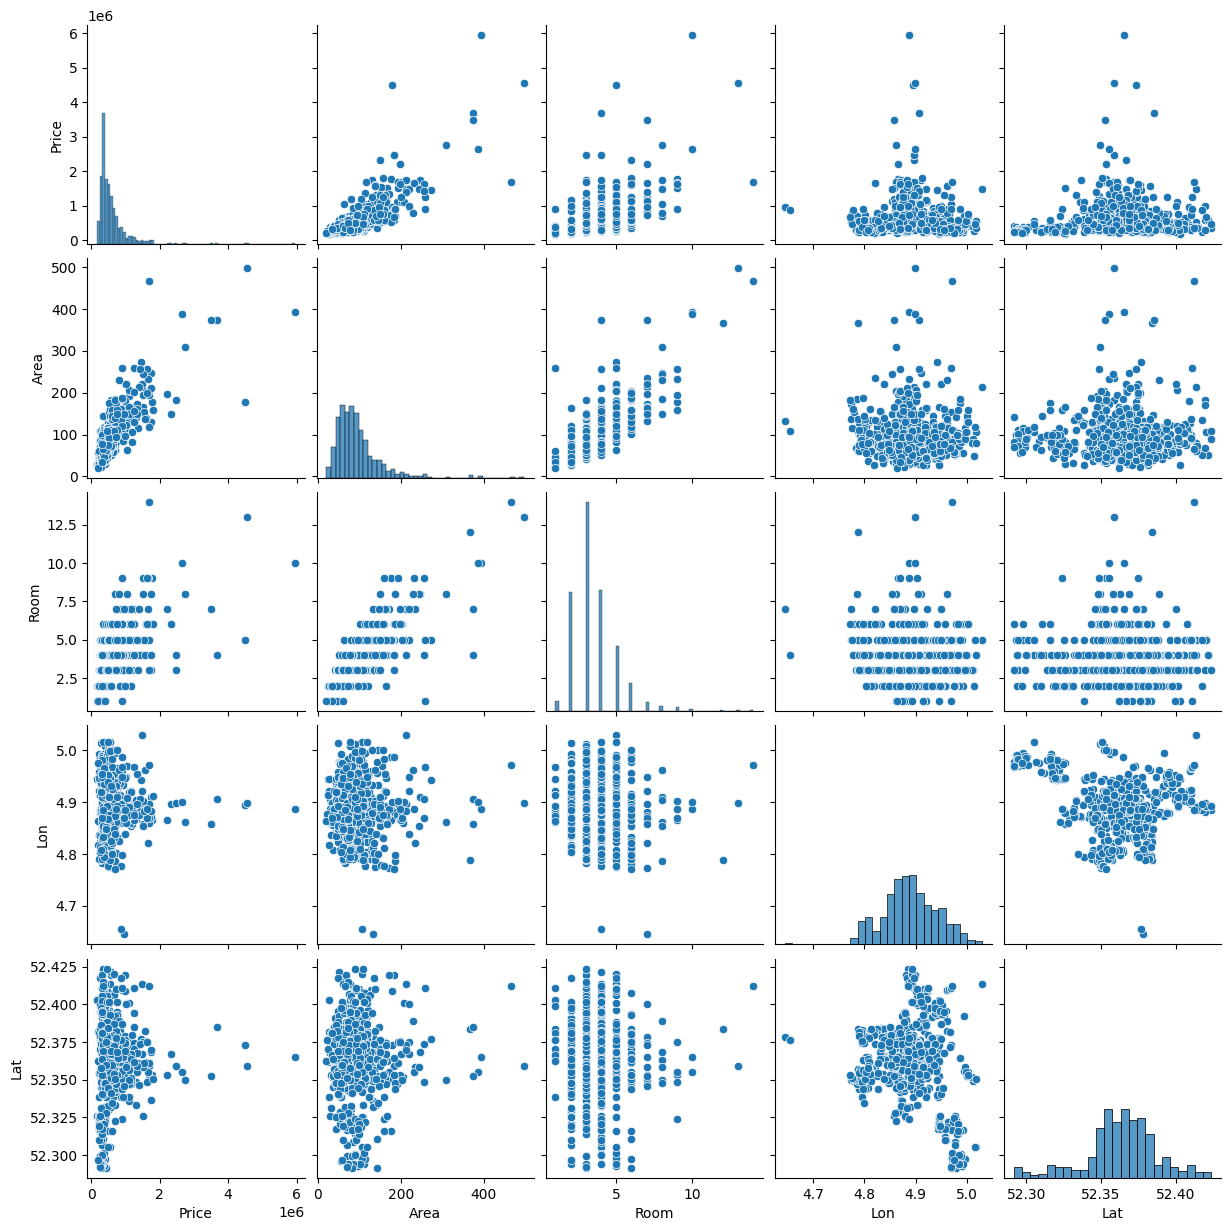

In [8]:
# Visualize sicrete and continuous features using a seaborn pairplot
sns.pairplot(
    data=data.astype(
        dict(zip(quantitative_list, len(quantitative_list) * ["float32"]))
    ),
    vars=quantitative_list,
)

**Summary**

 - `Price`, `Area` and `Room` are right-skewed. Hence we will apply a log transformation to attempt to normalize these features;
 - `Room` and `Area` appear positively correlated, which make sense as the Area increases as the number of room increases;
 - `Price` appears positively correlated with `Area`, making it a good candidate as a predictor. However, one can observe that the standard deviations of `Price`, monitored over different values of `Area`, are non-constant, leading to the possible issue of [Heteroskedasticity](https://www.investopedia.com/terms/h/heteroskedasticity.asp). 
 - `Lon` and `Lat` appears not correlated with `Price`. We will apply some feature engineering techniques to derive more meaningful features.

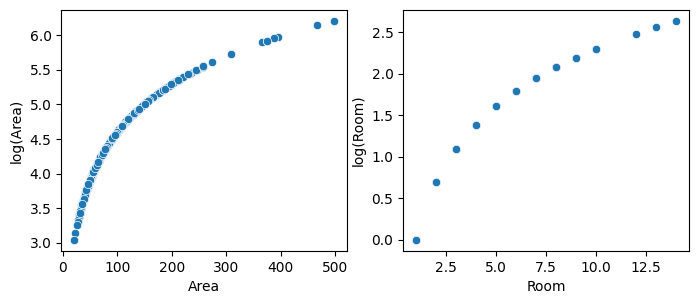

In [9]:
# create log transform of Area and Room
data = data.assign(
    **{
        "log(Area)": lambda df: np.log(df["Area"]),
        "log(Room)": lambda df: np.log(df["Room"]),
    }
)

# plot log transform of Price, Aeas and Room with respect to the original features
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
fig.tight_layout(w_pad=1.0)

for i, feat in zip([0, 1], ["Area", "Room"]):
    sns.scatterplot(data=data, x=feat, y=f"log({feat})", ax=axs[i])

Construct two features using Latitude and Longitude by deriving the distance between the centre of Amsterdamm, i.e. [Dam square](https://goo.gl/maps/3Vvx8CBGQms3GW2D8) and the House. We hypothesize that houses closer to the centre are more expensive. There are several ways of describing the distance between two points defined in (Lat, Lon) coordinated. In this case, we will construct:
1. Euclidean Distance
1. Haversine Distance
2. Manhattan Distance

In [10]:
# Define Lat and Lon of Dam Square using Google Maps
Lat_Centrum = 52.373095
Lon_Centrum = 4.893055

In [11]:
def euclidean_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Compute the euclidean distance between two points"""
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

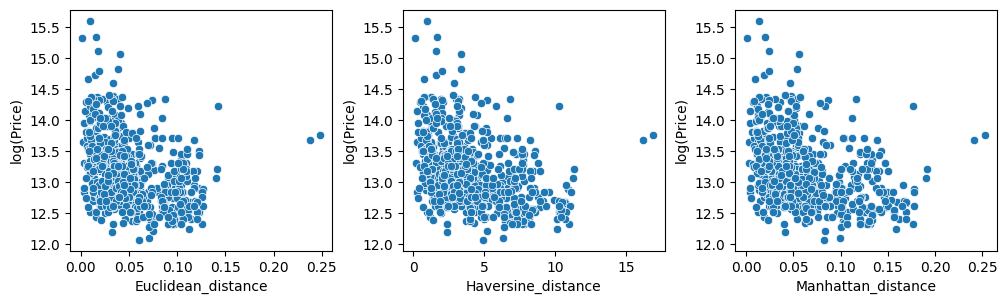

In [12]:
# generate distance features
data = data.assign(
    **{
        "Euclidean_distance": lambda df: euclidean_distance(
            df["Lat"], df["Lon"], Lat_Centrum, Lon_Centrum
        ),
        "Haversine_distance": lambda df: haversine_distance(
            df["Lat"], df["Lon"], Lat_Centrum, Lon_Centrum
        ),
        "Manhattan_distance": lambda df: np.abs(df["Lat"] - Lat_Centrum)
        + np.abs(df["Lon"] - Lon_Centrum),
    }
)

# Plot distance features with respect to the target
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
fig.tight_layout(w_pad=2.0)

for i, feat in zip(
    [0, 1, 2], ["Euclidean_distance", "Haversine_distance", "Manhattan_distance"]
):
    sns.scatterplot(data=data, x=feat, y="log(Price)", ax=axs[i])

In [13]:
# add new features to the quantitative_list
quantitative_list = quantitative_list + [
    "log(Price)",
    "log(Area)",
    "log(Room)",
    "Euclidean_distance",
    "Haversine_distance",
    "Manhattan_distance",
]

# check correlation of all features w.r.t the target and show only the significant ones
dict_results = correlation_analysis(
    data=data[quantitative_list].astype(np.float32),
    dropna="listwise",
    check_norm=True,
    col_list=["log(Price)"],
)
display(dict_results["summary"].round(3))

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,log(Price),Price,1.000,0.000,True,735
1,Spearman Rank,log(Price),Area,0.721,0.000,True,735
2,Spearman Rank,log(Price),Room,0.530,0.000,True,735
3,Spearman Rank,log(Price),Lon,-0.035,0.350,False,735
4,Spearman Rank,log(Price),Lat,0.070,0.059,False,735
5,Spearman Rank,log(Price),log(Area),0.721,0.000,True,735
6,Spearman Rank,log(Price),log(Room),0.530,0.000,True,735
7,Spearman Rank,log(Price),Euclidean_distance,-0.413,0.000,True,735
8,Spearman Rank,log(Price),Haversine_distance,-0.389,0.000,True,735
9,Spearman Rank,log(Price),Manhattan_distance,-0.409,0.000,True,735


In [14]:
dict_results = correlation_analysis(
    data=data[quantitative_list].astype(np.float32),
    dropna="listwise",
    check_norm=True,
    col_list=["log(Area)"],
    row_list=["log(Room)"],
)
display(dict_results["summary"].loc[lambda x: x["stat-sign"] == True].round(3))

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,log(Area),log(Room),0.78,0.0,True,735


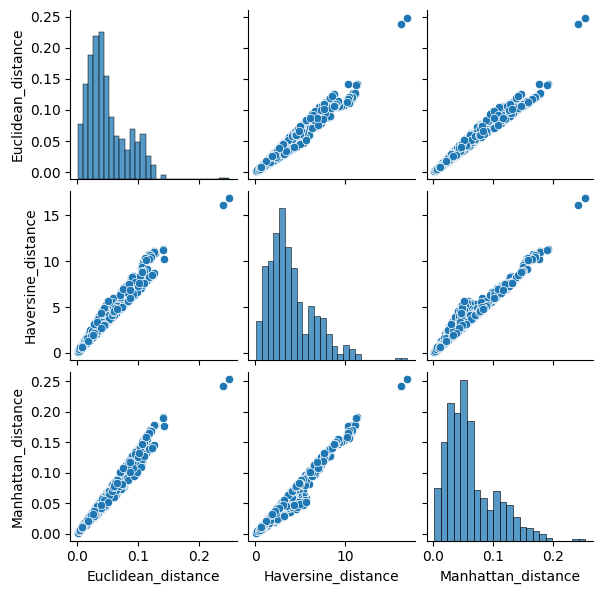

In [15]:
# check correlation, type of distribution and relationship with the target
sns.pairplot(
    data=data,
    vars=["Euclidean_distance", "Haversine_distance", "Manhattan_distance"],
    height=2,
    aspect=1,
)

The new features generated using `Lat` and `Lon` are negatively correlated with the target, meaning that the `Price` tends to decrease as the distance increases. On the other hand, the three distances are highly correlated, meaning we must select only one to avoid multi collinearity phenomenon. Furthermore, the logarithm or `Room` and `Area` reasonably correlate with `Price`. 

**Quick Model Train**

In [17]:
# drop na values for now
data = data.dropna(how="any")

# let's set as target the log(Price)
TARGET = "log(Price)"

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42
)

**Test1:** Run the model with original features

In [18]:
# scale numerical features using StandardScaler
quantitative_features = ['log(Area)', 'Euclidean_distance']
categorical_features = ['Region']

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(X_train, X_test, categorical_features)

X_train_1 = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_1 = pd.concat([X_test_num, X_test_cat], axis=1)

# Fit logistic regression using sklearn
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_1, y_train)

print("r2 score Linear Regression: ", lr.score(X_test_1, y_test))

# report_lr_original = regression_report(
#     y_true=y_test,
#     y_pred=logreg.predict(X_test_1),
#     label="LR original",
#     show_description=False,
# )

# # Fit random forest using sklearn
rf = DecisionTreeRegressor(random_state=42)
rf.fit(X_train_1, y_train)

print("r2 score Decision Tree: ", rf.score(X_test_1, y_test))

# report_rf_original = classification_report(
#     y_true=y_test,
#     y_pred=rf.predict(X_test_1),
#     label="RF original",
#     show_description=False,
# )



r2 score Linear Regression:  0.7923116165872761
r2 score Decision Tree:  0.771499239726541


C:\Users\Adobe2023-PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.79 of r2 score is very good considering that 0.5 is generally good.